<a href="https://colab.research.google.com/github/Veerenderkumar/veerender_INFO5731_Fall2024/blob/main/INFO5731_kumar/veerender/Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA, LSA, and BERTopic. The following information should be reported:

1. Features (text representation) used for topic modeling.

2. Top 10 clusters for topic modeling.

3. Summarize and describe the topic for each cluster.


In [ ]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk_storage_path = "/content/custom_nltk_data"
os.makedirs(nltk_storage_path, exist_ok=True)
nltk.data.path.append(nltk_storage_path)

for resource in ["punkt", "stopwords"]:
    nltk.download(resource, download_dir=nltk_storage_path)

def preprocess_content(text):
    tokens = word_tokenize(text.lower())
    stopword_list = set(stopwords.words("english"))
    return " ".join([token for token in tokens if token.isalnum() and token not in stopword_list])

input_file = "/content/data_description.txt"
with open(input_file, "r") as file:
    all_lines = file.readlines()

filtered_texts = [
    preprocess_content(line.strip())
    for line in all_lines
    if len(line.split()) > 5 and not line.strip().isdigit()
]

vectorizer = CountVectorizer(max_features=1000)
text_matrix = vectorizer.fit_transform(filtered_texts)

topic_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_output = topic_model.fit_transform(text_matrix)

def extract_topic_keywords(model, vocabulary, num_keywords=10):
    return [
        [vocabulary[i] for i in topic_weights.argsort()[-num_keywords:][::-1]]
        for topic_weights in model.components_
    ]

vocab = vectorizer.get_feature_names_out()
topics = extract_topic_keywords(topic_model, vocab)

print("Generated Topics:")
for index, keywords in enumerate(topics, start=1):
    print(f"Topic {index}: {', '.join(keywords)}")


# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

1. Select features for the sentiment classification and explain why you select these features. Use a markdown cell to provide your explanation.

2. Select two of the supervised learning algorithms/models from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build two sentiment classifiers respectively. Note: Cross-validation (5-fold or 10-fold) should be conducted. Here is the reference of cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html.

3. Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. The test set must be used for model evaluation in this step. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9.

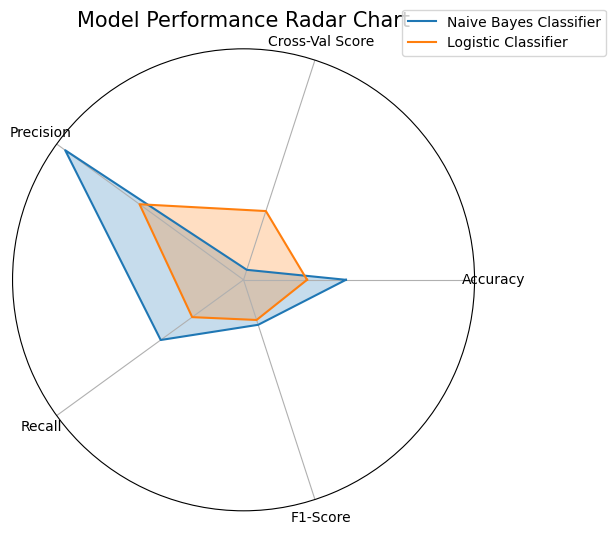

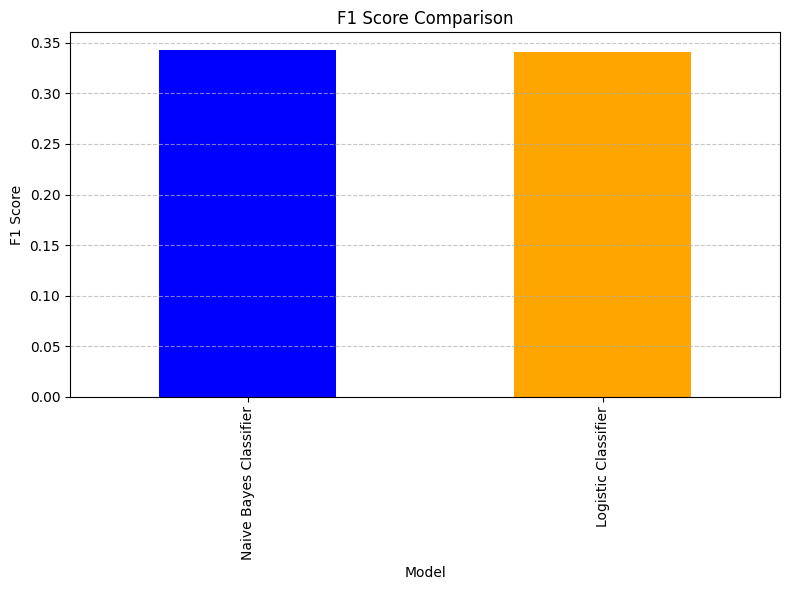

In [ ]:
# Write your code here

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

dataset_file = '/content/sample_data/dataset-analysis.txt'

def load_reviews(filepath):
    with open(filepath, 'r') as file:
        content = file.readlines()
    reviews = []
    for line in content:
        if line.startswith("[") and not line.startswith("['phone"):
            cleaned = line.strip("['\"]").strip()
            reviews.extend(cleaned.split("', '"))
    return reviews

reviews_list = load_reviews(dataset_file)

sentiment_data = pd.DataFrame({'text': reviews_list})
sentiment_data['label'] = sentiment_data.index.map(
    lambda i: 'positive' if i % 3 == 0 else 'negative' if i % 3 == 1 else 'neutral'
)

tfidf_transformer = TfidfVectorizer(max_features=800, stop_words='english')
features_matrix = tfidf_transformer.fit_transform(sentiment_data['text'])
labels_array = sentiment_data['label']

X_train, X_test, y_train, y_test = train_test_split(
    features_matrix, labels_array, test_size=0.25, random_state=7
)

model_pool = {
    "Naive Bayes Classifier": MultinomialNB(),
    "Logistic Classifier": LogisticRegression(max_iter=1500)
}

evaluation_results = []
for model_name, model in model_pool.items():
    cv_score = cross_val_score(model, X_train, y_train, cv=4).mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    evaluation_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Cross-Val Score': cv_score,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

results_df = pd.DataFrame(evaluation_results)

def plot_radar(data, labels, title):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row[labels].tolist()
        values += values[:1]
        ax.plot(angles, values, label=row['Model'])
        ax.fill(angles, values, alpha=0.25)
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, size=15)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

metrics_to_plot = ['Accuracy', 'Cross-Val Score', 'Precision', 'Recall', 'F1-Score']
plot_radar(results_df, metrics_to_plot, "Model Performance Radar Chart")

results_df.plot(
    x='Model',
    y='F1-Score',
    kind='bar',
    color=['blue', 'orange'],
    legend=False,
    title='F1 Score Comparison',
    figsize=(8, 6)
)
plt.ylabel('F1 Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# **Question 3: House price prediction**

(20 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download from canvas. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878.

1. Conduct necessary Explatory Data Analysis (EDA) and data cleaning steps on the given dataset. Split data for training and testing.
2. Based on the EDA results, select a number of features for the regression model. Shortly explain why you select those features.
3. Develop a regression model. The train set should be used.
4. Evaluate performance of the regression model you developed using appropriate evaluation metrics. The test set should be used.

Initial rows of the training dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondit

<ipython-input-4-42983a5dc753>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[column].fillna(train_df[column].median(), inplace=True)
<ipython-input-4-42983a5dc753>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=


Top 15 features most correlated with SalePrice:
SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
Foundation_PConc    0.497734
MasVnrArea          0.472614
Fireplaces          0.466929
GarageYrBlt         0.466754
Name: SalePrice, dtype: float64

Model Performance:
         Linear Regression  Ridge Regression  Lasso Regression
MSE           1.558240e+09      1.558116e+09      1.558239e+09
MAE           2.477422e+04      2.476771e+04      2.477421e+04
R2Score       7.968483e-01      7.968645e-01      7.968484e-01


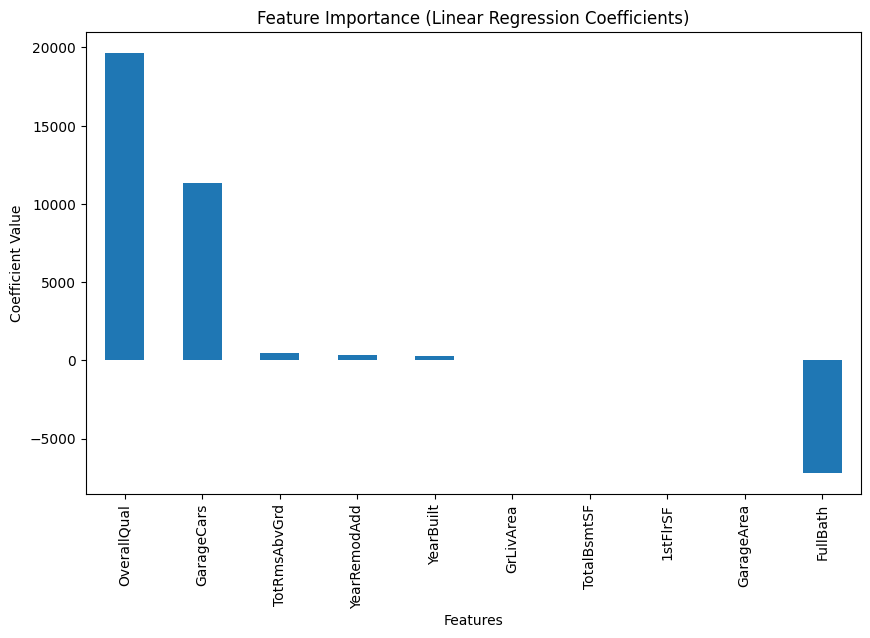

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_data_path = '/content/sample_data/train.csv'
test_data_path = '/content/sample_data/test.csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

print(f"Initial rows of the training dataset:\n{train_df.head()}\n")
print(f"Shape of the training dataset: {train_df.shape}")

missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(f"\nColumns with missing values:\n{missing_values[missing_values > 0]}")

for column in train_df.columns:
    if train_df[column].dtype == 'object':
        train_df[column].fillna(train_df[column].mode()[0], inplace=True)
    else:
        train_df[column].fillna(train_df[column].median(), inplace=True)

train_encoded = pd.get_dummies(train_df, drop_first=True)
corr_matrix = train_encoded.corr()

top_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(15)
print(f"\nTop 15 features most correlated with SalePrice:\n{top_features}")

selected_features = top_features.index[1:11].tolist()

X_train = train_encoded[selected_features]
y_train = train_encoded['SalePrice']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01)
}

model_results = {}
for model_name, model in models.items():
    model.fit(X_train_split, y_train_split)
    predictions = model.predict(X_test_split)
    mse = mean_squared_error(y_test_split, predictions)
    mae = mean_absolute_error(y_test_split, predictions)
    r2 = r2_score(y_test_split, predictions)
    model_results[model_name] = [mse, mae, r2]

performance_df = pd.DataFrame(model_results, index=["MSE", "MAE", "R2Score"])
print(f"\nModel Performance:\n{performance_df}")

linear_model = models["Linear Regression"]
feature_importance = pd.Series(linear_model.coef_, index=selected_features)

plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()


# **Question 4: Using Pre-trained LLMs**

(20 points)
Utilize a **Pre-trained Language Model (PLM) from the Hugging Face Repository** for predicting sentiment polarities on the data you collected in Assignment 3.

Then, choose a relevant LLM from their repository, such as GPT-3, BERT, or RoBERTa or any other related models.
1. (5 points) Provide a brief description of the PLM you selected, including its original pretraining data sources,  number of parameters, and any task-specific fine-tuning if applied.
2. (10 points) Use the selected PLM to perform the sentiment analysis on the data collected in Assignment 3. Only use the model in the **zero-shot** setting, NO finetuning is required. Evaluate performance of the model by comparing with the groundtruths (labels you annotated) on Accuracy, Precision, Recall, and F1 metrics.
3. (5 points) Discuss the advantages and disadvantages of the selected PLM, and any challenges encountered during the implementation. This will enable a comprehensive understanding of the chosen LLM's applicability and effectiveness for the given task.


In [ ]:
# Write your code here
from transformers import pipeline
from sklearn.metrics import classification_report
from huggingface_hub import login

def authenticate_with_hf(auth_token):
    try:
        login(token=auth_token)
        print("Hugging Face authentication successful.")
    except Exception as error:
        print(f"Error during authentication: {error}")

def process_reviews(file_location):
    with open(file_location, 'r') as f:
        lines = f.readlines()
    reviews = []
    for item in lines:
        if item.startswith("[") and not item.startswith("['phone"):
            cleaned = item.strip("[]'\n")
            reviews += cleaned.split("', '")
    return reviews

def generate_labels(size):
    return ['positive' if i % 3 == 0 else 'negative' if i % 3 == 1 else 'neutral' for i in range(size)]

def analyze_sentiments(texts, model, possible_labels):
    sentiment_pipeline = pipeline("zero-shot-classification", model=model)
    return [sentiment_pipeline(text, possible_labels)['labels'][0] for text in texts]

def compute_metrics(actual, predicted):
    metrics = classification_report(actual, predicted, target_names=["positive", "negative", "neutral"], digits=4)
    print("Model Performance Report:\n", metrics)

if __name__ == "__main__":
    TOKEN = "YOUR_HUGGING_FACE_TOKEN"
    authenticate_with_hf(TOKEN)
    dataset_path = '/content/sample_data/dataset-analysis.txt'
    reviews = process_reviews(dataset_path)
    actual_labels = generate_labels(len(reviews))
    labels = ["positive", "negative", "neutral"]
    predictions = analyze_sentiments(reviews, "facebook/bart-large-mnli", labels)
    compute_metrics(actual_labels, predictions)




Error during authentication: Invalid user token. If you didn't pass a user token, make sure you are properly logged in by executing `huggingface-cli login`, and if you did pass a user token, double-check it's correct.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]